In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn

# Import moving MNIST

In [2]:
Moving_MNIST = np.load('data/mnist_test_seq.npy')
Moving_MNIST = Moving_MNIST / 255
Moving_MNIST.shape

(20, 10000, 64, 64)

# Give `torch` the data

In [3]:
# Making into PyTorch tensor
Moving_MNIST_tensor = torch.from_numpy(Moving_MNIST)

# Putting the existing dimensions into appropriate order
Moving_MNIST_tensor = Moving_MNIST_tensor.permute(1, 0, 2, 3)

# Added the acknowledge that this is 1 spectral band
Moving_MNIST_tensor = Moving_MNIST_tensor.unsqueeze(2)

# Checking shape
Moving_MNIST_tensor.shape

torch.Size([10000, 20, 1, 64, 64])

# Train/validation split

In [4]:
train_indices = np.random.choice(range(10000), size = 8000, replace = False)

OutofSample_indices = [index for index in range(10000) if index not in train_indices.tolist()]
validation_indices = np.random.choice(OutofSample_indices, size = 1000, replace = False)

# Creating 9 data subsets, which the data will be uniformly sampled into and subsetted from 20 frames to [11, 20] frames, keep tracking of the number of frames omitted (i.e. $\Delta{t}$ where 1 = no omission, 2 = 1 omission, etc...)

In [5]:
# Creating empty nested lists to store data...
train_data = []
for i in range(9):
    train_data.append([])
# ...and time steps in
train_delta_Ts = []
for i in range(9):
    train_delta_Ts.append([])

# For the train (above) and validation (below) data
validation_data = []
for i in range(9):
    validation_data.append([])
validation_delta_Ts = []
for i in range(9):
    validation_delta_Ts.append([])

In [6]:
for i in range(Moving_MNIST_tensor.shape[0]):
    
    # Determine how many frames to keep out of the 20 possible
    #     leaving 11 so that there is at least 10 for input and 1 for out
    num_frames = np.random.choice(range(11, 20))
    
    # Determining what index that places the data in
    data_index = (num_frames - 11)
    
    # Now that we have a number to keep, picking which specific ones to keep
    frame_indices = np.random.choice(range(20),
                                     size = num_frames,
                                     replace = False)
    
    # Sorting those frames to proper chronological order
    sorted_frame_indices = sorted(frame_indices)
    
    # Getting the missing-frames-data
    frame_data = Moving_MNIST_tensor[i, sorted_frame_indices]
    frame_data = frame_data.unsqueeze(dim = 0)
    
    # Determining "time steps" between indices
    #     1 = proper sequence
    #     2 = missing one index inbetween
    #     3 = missing two indices inbetween
    #     etc...
    delta_Ts = []
    for j in range(1, len(sorted_frame_indices)):
        delta_Ts.append(sorted_frame_indices[j] - sorted_frame_indices[j-1])
        
    # Getting delta_Ts as an image band
    #     "num_frames - 1" because it's not necessary for the first band
    #     since it has no prior reference
    delta_T_tensors = torch.ones([1, num_frames - 1, 1, 64, 64])
    for k in range(delta_T_tensors.shape[1]):
        delta_T_tensors[:, k, :, :, :] *= delta_Ts[k]
    
    # Storing it and its time steps appropriately
    if i in train_indices:
        # Initiating the tensor within the empty list
        if train_data[data_index] == []:
            train_data[data_index].append(frame_data)
            train_delta_Ts[data_index].append(delta_T_tensors)
        # Or expanding upon the tensor
        else:
            train_data[data_index][0] = torch.cat([train_data[data_index][0],
                                                   frame_data])
            train_delta_Ts[data_index][0] = torch.cat([train_delta_Ts[data_index][0],
                                                       delta_T_tensors])
    elif i in validation_indices:
        if validation_data[data_index] == []:
            validation_data[data_index].append(frame_data)
            validation_delta_Ts[data_index].append(delta_T_tensors)
        else:
            validation_data[data_index][0] = torch.cat([validation_data[data_index][0],
                                                        frame_data])
            validation_delta_Ts[data_index][0] = torch.cat([validation_delta_Ts[data_index][0],
                                                            delta_T_tensors])

In [7]:
print('For train data...')
for i in range(len(train_data)):
    print(train_data[i][0].shape)

print('\nFor validation data...')
for i in range(len(validation_data)):
    print(validation_data[i][0].shape)

For train data...
torch.Size([849, 11, 1, 64, 64])
torch.Size([903, 12, 1, 64, 64])
torch.Size([887, 13, 1, 64, 64])
torch.Size([873, 14, 1, 64, 64])
torch.Size([935, 15, 1, 64, 64])
torch.Size([858, 16, 1, 64, 64])
torch.Size([930, 17, 1, 64, 64])
torch.Size([843, 18, 1, 64, 64])
torch.Size([922, 19, 1, 64, 64])

For validation data...
torch.Size([116, 11, 1, 64, 64])
torch.Size([110, 12, 1, 64, 64])
torch.Size([114, 13, 1, 64, 64])
torch.Size([98, 14, 1, 64, 64])
torch.Size([110, 15, 1, 64, 64])
torch.Size([113, 16, 1, 64, 64])
torch.Size([117, 17, 1, 64, 64])
torch.Size([101, 18, 1, 64, 64])
torch.Size([121, 19, 1, 64, 64])


# Separating $x$ and $y$

In [8]:
def sep_x_y(tensor_to_separate):
    x = []
    y = []
    for i in range(len(tensor_to_separate)):
        current_seq = tensor_to_separate[i, :, :, :, :]
        for j in range(current_seq.shape[0]):
            if j >= 10:
                current_x = current_seq[(j-10):j].numpy()
                x.append(current_x)
                current_y = current_seq[j].unsqueeze(dim = 0).numpy()
                y.append(current_y)
    x = np.asarray(x)
    x = torch.from_numpy(x).type(torch.FloatTensor)
    y = np.asarray(y)
    y = torch.from_numpy(y).type(torch.FloatTensor)
    return(x, y)

In [9]:
x_11, y_11 = sep_x_y(train_data[0][0])
x_12, y_12 = sep_x_y(train_data[1][0])
x_13, y_13 = sep_x_y(train_data[2][0])
x_14, y_14 = sep_x_y(train_data[3][0])
x_15, y_15 = sep_x_y(train_data[4][0])
x_16, y_16 = sep_x_y(train_data[5][0])
x_17, y_17 = sep_x_y(train_data[6][0])
x_18, y_18 = sep_x_y(train_data[7][0])
x_19, y_19 = sep_x_y(train_data[8][0])

x_11_validation, y_11_validation = sep_x_y(validation_data[0][0])
x_12_validation, y_12_validation = sep_x_y(validation_data[1][0])
x_13_validation, y_13_validation = sep_x_y(validation_data[2][0])
x_14_validation, y_14_validation = sep_x_y(validation_data[3][0])
x_15_validation, y_15_validation = sep_x_y(validation_data[4][0])
x_16_validation, y_16_validation = sep_x_y(validation_data[5][0])
x_17_validation, y_17_validation = sep_x_y(validation_data[6][0])
x_18_validation, y_18_validation = sep_x_y(validation_data[7][0])
x_19_validation, y_19_validation = sep_x_y(validation_data[8][0])

# Consolidating the 9 subsets

In [10]:
x = torch.cat([x_11, x_12, x_13,
               x_14, x_15, x_16,
               x_17, x_18, x_19])
y = torch.cat([y_11, y_12, y_13,
               y_14, y_15, y_16,
               y_17, y_18, y_19])

x_validation = torch.cat([x_11_validation, x_12_validation, x_13_validation,
                          x_14_validation, x_15_validation, x_16_validation,
                          x_17_validation, x_18_validation, x_19_validation])
y_validation = torch.cat([y_11_validation, y_12_validation, y_13_validation,
                          y_14_validation, y_15_validation, y_16_validation,
                          y_17_validation, y_18_validation, y_19_validation])

# Viewing the overlaid $(x, y)$ sequences where blue = early $x$ frame, green = late $x$ frame, and red = $y$ frame

In [13]:
def plot_ex():
    random_index = np.random.choice(len(x_validation))
    for i in range(10):
        if i > 5:
            plt.imshow(x_validation[random_index, i, 0], alpha = 0.25, cmap = 'Greens')
        else:
            plt.imshow(x_validation[random_index, i, 0], alpha = 0.5, cmap = 'Blues')
    plt.imshow(y_validation[random_index, 0, 0], cmap = 'Reds', alpha = 0.25)
    plt.pause(0.01);

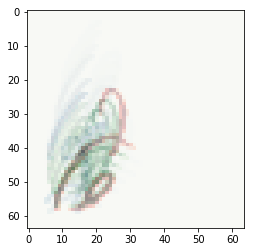

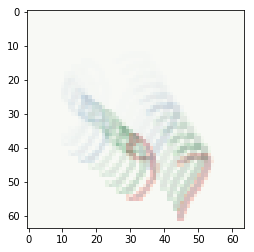

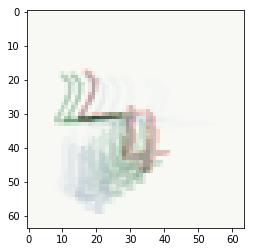

In [14]:
plot_ex()
plot_ex()
plot_ex()

# Defining the model

In [15]:
import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias, GPU):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        self.GPU         = GPU
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size):
        to_return = (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)),
                     Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)))
        if self.GPU:
            to_return = (to_return[0].cuda(), to_return[1].cuda())
        return(to_return)


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first, bias, return_all_layers, GPU):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.GPU = GPU

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,
                                          GPU=self.GPU))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [16]:
# Picking one of the like-sequence tensors within the list to set parameters
channels = x.shape[2]
height = x.shape[3]
width = x.shape[4]

In [17]:
conv_lstm = ConvLSTM(input_size = (height,
                                   width),
                     input_dim = channels,
                     hidden_dim = [128, 64, 64, 1],
                     kernel_size = (5, 5),
                     num_layers = 4,
                     batch_first = True,
                     bias = True,
                     return_all_layers = False,
                     GPU = True)

In [18]:
conv_lstm.cuda()

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(129, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(65, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

# Training

In [19]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(conv_lstm.parameters())

In [20]:
from torch.utils import data

class train_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x[IDs, :, :, :, :]
        curr_y = y[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_y)
    
class validation_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x_validation[IDs, :, :, :, :]
        curr_y = y_validation[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_y)

In [21]:
training_set = train_Dataset(data_indices = range(y.shape[0]))
validation_set = validation_Dataset(data_indices = range(y_validation.shape[0]))

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = training_set,
                                           batch_size = batch_size,
                                           shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_set,
                                                batch_size = batch_size,
                                                shuffle = True)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
conv_lstm = torch.nn.DataParallel(conv_lstm)

In [24]:
loss_list = []
epochs = int(np.ceil((7*10**5) / (x.shape[0])))
for i in range(epochs):
    for data in train_loader:

        # data loader
        batch_x, batch_y = data

        # move to GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # run model and get the prediction
        batch_y_hat = conv_lstm(batch_x)
        batch_y_hat = batch_y_hat[0][0][:, -2:-1, :, :, :]

        # calculate and store the loss
        batch_loss = loss(batch_y, batch_y_hat)
        loss_list.append(batch_loss.item())

        # update parameters
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    print('Epoch: ', i, '\n\tBatch loss: ', batch_loss.item(), '\n')

Epoch:  0 
	Batch loss:  0.026458468288183212 

Epoch:  1 
	Batch loss:  0.024416333064436913 

Epoch:  2 
	Batch loss:  0.026674434542655945 

Epoch:  3 
	Batch loss:  0.020224059000611305 

Epoch:  4 
	Batch loss:  0.023150352761149406 

Epoch:  5 
	Batch loss:  0.021289145573973656 

Epoch:  6 
	Batch loss:  0.021601008251309395 

Epoch:  7 
	Batch loss:  0.025517204776406288 

Epoch:  8 
	Batch loss:  0.0220030490309 

Epoch:  9 
	Batch loss:  0.021812530234456062 

Epoch:  10 
	Batch loss:  0.019466962665319443 

Epoch:  11 
	Batch loss:  0.020250407978892326 

Epoch:  12 
	Batch loss:  0.018998702988028526 

Epoch:  13 
	Batch loss:  0.019118022173643112 

Epoch:  14 
	Batch loss:  0.022934427484869957 

Epoch:  15 
	Batch loss:  0.01903742365539074 

Epoch:  16 
	Batch loss:  0.018058082088828087 

Epoch:  17 
	Batch loss:  0.021866662427783012 



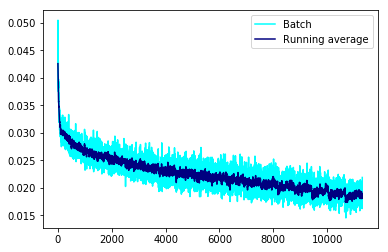

In [25]:
plt.plot(loss_list,
         color = 'cyan',
         label = 'Batch')
plt.plot(np.convolve(loss_list, 1/10*np.ones(10))[10:-10],
         color = 'navy',
         label = 'Running average')
plt.legend();

# Getting random predictions for the validation set

In [27]:
rand_x, rand_y = next(iter(validation_loader))

rand_y_hat = conv_lstm(rand_x.to(device))[0][0][:, -2:-1, :, :, :]
rand_y_hat = rand_y_hat.cpu().data.numpy()

# View prediction on sequence ($\hat{y}$ on $x$)

In [30]:
def plot_random_validation_pred():
    f, axarr = plt.subplots(1, 2)
    f.set_figheight(4)
    f.set_figwidth(8)
    random_index = np.random.choice(len(rand_x))
    for i in range(10):
        axarr[0].imshow(rand_x[random_index, i, 0], alpha = 0.25, cmap = 'gist_gray')
        axarr[1].imshow(rand_x[random_index, i, 0], alpha = 0.25, cmap = 'gist_gray')
    axarr[0].imshow(rand_y[random_index, 0, 0], cmap = 'Reds', alpha = 0.5)
    axarr[0].set_title('Red = True', fontsize = 15)
    axarr[1].imshow(rand_y_hat[random_index, 0, 0], cmap = 'Blues', alpha = 0.5)
    axarr[1].set_title('Blue = Predicted', fontsize = 15);

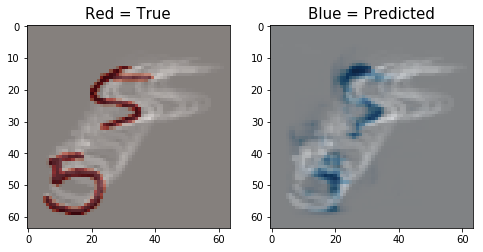

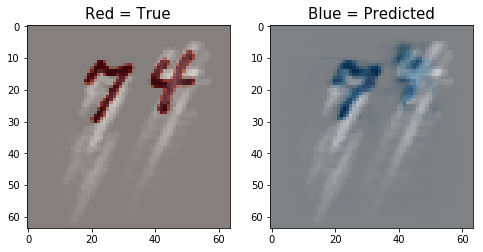

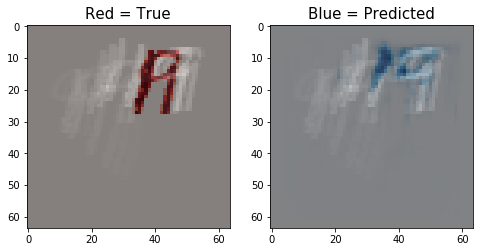

In [31]:
plot_random_validation_pred()
plot_random_validation_pred()
plot_random_validation_pred()

# View prediction on true ($\hat{y}$ on $y$)

In [32]:
def overlay_pred_true():
    random_index = np.random.choice(len(rand_x))
    plt.imshow(rand_y[random_index, 0, 0], cmap = 'Reds', alpha = 0.5)
    plt.imshow(rand_y_hat[random_index, 0, 0], cmap = 'Blues', alpha = 0.5)
    plt.pause(0.01)

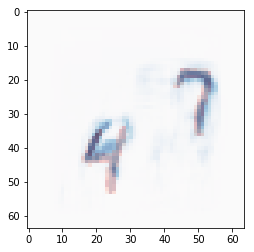

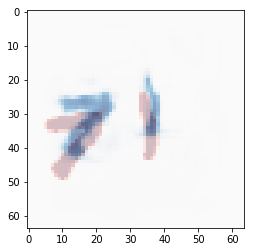

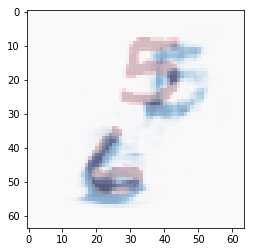

In [33]:
overlay_pred_true()
overlay_pred_true()
overlay_pred_true()

# Mimicking sequence-to-sequence by shuffling in predictions

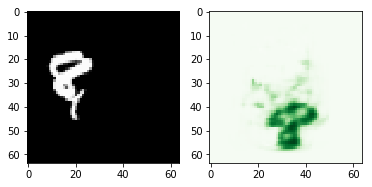

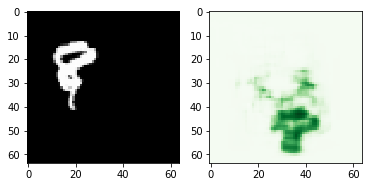

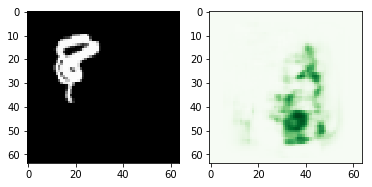

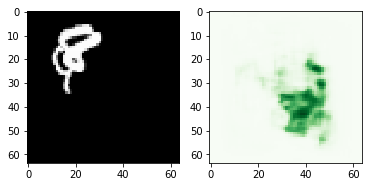

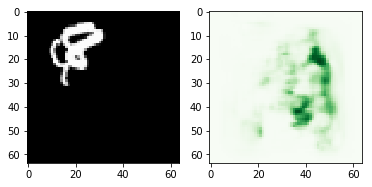

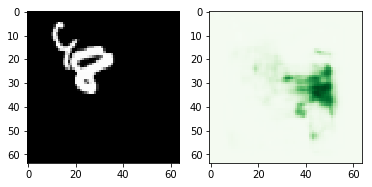

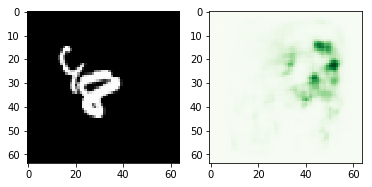

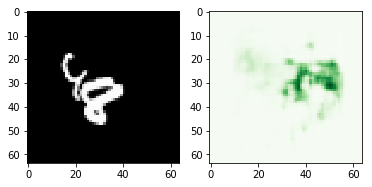

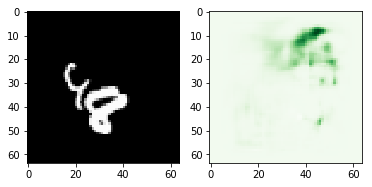

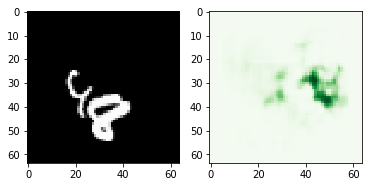

In [34]:
random_index = np.random.choice(len(rand_x) - 1)
rand_x = rand_x[random_index:(random_index+1)]

for i in range(10):
    f, axarr = plt.subplots(1, 2)
    f.set_figheight(3)
    f.set_figwidth(6)
    axarr[0].imshow(rand_x[0, 0, 0], cmap = 'gist_gray')
    rand_y_hat = conv_lstm(rand_x.to(device))[0][0][:, -2:-1, :, :, :]
    axarr[1].imshow(rand_y_hat[0, 0, 0].data.cpu().numpy(), cmap = 'Greens')
    rand_x = torch.cat([rand_x, rand_y_hat.data.cpu()], dim = 1)
    rand_x = rand_x[:, 1:]
    plt.pause(0.01)